In [2]:
import numpy as np
import rdkit
from mordred import Calculator, descriptors
from glob import glob
from rdkit import rdBase, Chem ,DataStructs
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import MolDrawing, DrawingOptions
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import rdFMCS
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem import BRICS
from rdkit.Chem.Descriptors import NumValenceElectrons
from rdkit.Chem import Descriptors
from rdkit.Chem.rdMolDescriptors import GetUSRScore, GetUSRCAT
from rdkit.Avalon import pyAvalonTools
import pubchempy as pcp
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from rdkit.Chem import Recap
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem import rdRGroupDecomposition as rdRGD
from rdkit.ML.Descriptors import MoleculeDescriptors
from sklearn.decomposition import PCA
import nglview
%matplotlib inline

In [6]:
df =pd.read_csv("Final_training_set.csv")
ls=df.values.tolist()

positive_ls =[i[0] for i in ls if i[5]==1]
print(len(positive_ls))

negative_ls = [i[0] for i in ls if i[5]==0]
print(len(negative_ls))

positive_mols=[Chem.MolFromSmiles(i) for i in positive_ls]
negative_mols =[Chem.MolFromSmiles(i) for i in negative_ls]


df =pd.read_csv("predictions.csv")
data_ls=df.values.tolist()
pred_ls=[i[0] for i in data_ls if i[2]>0.5]
pred_mols = [Chem.MolFromSmiles(i) for i in pred_ls]
print(len(pred_mols))

480
7204
121


280
('[5*]N1CCN(C)CC1', 10)
('[3*]O[C@H]1C[C@@](C)(OC)[C@@H](O)[C@H](C)O1', 7)
('[13*][C@H]1C[C@@](C)(OC)[C@@H](O)[C@H](C)O1', 7)
('[1*]C(=O)C(=NOC)c1csc(N)n1', 6)
('[3*]O[C@@H]1O[C@H](C)[C@@H]([15*])[C@H](N(C)C)[C@H]1O', 6)
('[3*]O[C@H]1[C@H](N(C)C)[C@@H](O)[C@H]([13*])O[C@@H]1C', 6)
('[13*][C@@H]1O[C@H](C)[C@@H]([15*])[C@H](N(C)C)[C@H]1O', 6)
('[3*]O[C@@H]1O[C@H](C)[C@@H](O[3*])[C@H](N(C)C)[C@H]1O', 6)
('[5*]N1CCNCC1', 5)
('[3*]O[C@@H]1O[C@H](C)C[C@H](N(C)C)[C@H]1O', 5)
('[13*][C@@H]1O[C@H](C)C[C@H](N(C)C)[C@H]1O', 5)
('[16*]c1cc2c(cc1F)c(=O)c(C(=O)O)cn2C1CC1', 4)
('[16*]c1c(F)cc2c(=O)c(C(=O)O)cn(C3CC3)c2c1OC', 3)
('[3*]O[C@H]1C[C@@](C)(O)[C@@H](O)[C@H](C)O1', 3)
('[13*][C@H]1C[C@@](C)(O)[C@@H](O)[C@H](C)O1', 3)
('[15*][C@H]1[C@H](C)[C@@H]([15*])[C@](C)(O)C[C@@H](C)C(=O)[C@H](C)[C@@H](O)[C@](C)(O)[C@@H](CC)OC(=O)[C@@H]1C', 3)
('[3*]O[C@H]1[C@H](C)[C@@H](O[3*])[C@](C)(O)C[C@@H](C)C(=O)[C@H](C)[C@@H](O)[C@](C)(O)[C@@H](CC)OC(=O)[C@@H]1C', 3)
('[3*]O[C@H]1[C@H](C)[C@@H]([15*])[C@](C)(O)

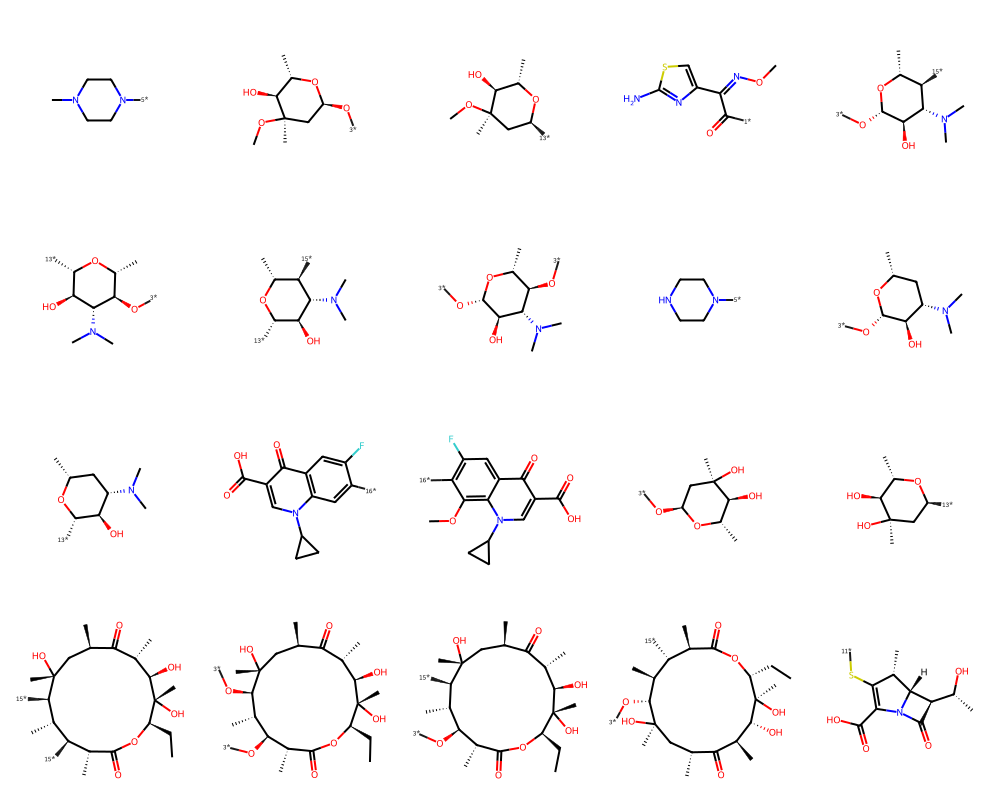

In [8]:
allfrags = {}
negative_allfrags ={}
pred_allfrags ={}
def fragment_recursive(mol, frags):
    #try:
        bonds = list(BRICS.FindBRICSBonds(mol))
        if len(bonds) == 0:
            frags.append(Chem.MolToSmiles(mol))
            return frags
        
        idxs, labs = list(zip(*bonds))
        # print(bonds)
        # print(idxs, labs)
        bond_idxs = []
        for a1, a2 in idxs:
            bond = mol.GetBondBetweenAtoms(a1, a2)
            bond_idxs.append(bond.GetIdx())
        order = np.argsort(bond_idxs).tolist()
        bond_idxs = [bond_idxs[i] for i in order]
        broken = Chem.FragmentOnBonds(mol,
                                      bondIndices=[bond_idxs[0]],
                                      dummyLabels=[(0, 0)])
        head,tail = Chem.GetMolFrags(broken, asMols=True)
        #print(mol_to_smiles(head), mol_to_smiles(tail))
        frags.append(Chem.MolToSmiles(head))
        return fragment_recursive(tail, [frags])
    #except Exception as e:
        #print (e)
        #pass
def remove_number(mol_smiles):
    ls=["[{}*]".format(i) for i in range(1,21)]
    for i in ls:
        if i in mol_smiles:
            mol_smiles=mol_smiles.replace(i,"[H]")
    return mol_smiles        


for mol in positive_mols:
    #pieces = fragment_recursive(mol,[])
    pieces = BRICS.BRICSDecompose(mol,minFragmentSize=5)
    #pieces=Recap.RecapDecompose(mol).GetLeaves().keys()
    #pieces=Recap.RecapDecompose(mol).GetAllChildren().keys()
    for piece in pieces: 
        #piece = remove_number(piece)
        allfrags[piece]=allfrags.get(piece,0) + 1

for mol in negative_mols:
    pieces = BRICS.BRICSDecompose(mol,minFragmentSize=5)
    for piece in pieces: 
        #piece = remove_number(piece)
        negative_allfrags[piece]=negative_allfrags.get(piece,0) + 1

for mol in pred_mols:
    pieces = BRICS.BRICSDecompose(mol,minFragmentSize=5)
    for piece in pieces: 
        #piece = remove_number(piece)
        pred_allfrags[piece]=pred_allfrags.get(piece,0) + 1


allfrags_list = list(allfrags.items())
allfrags_list.sort(key=lambda x:x[1], reverse=True)

negative_allfrags_list = list(negative_allfrags.items())
negative_allfrags_list.sort(key=lambda x:x[1], reverse=True)

pred_allfrags_list = list(pred_allfrags.items())
pred_allfrags_list.sort(key=lambda x:x[1], reverse=True)

print(len(pred_allfrags_list))
#print(len(negative_allfrags_list)
for i in range(20):
    print(pred_allfrags_list[i])
frag_top20=[allfrags_list[i][0] for i in range(20)]
fragmol_top20=[Chem.MolFromSmiles(i) for i in frag_top20]

negative_frag_top20=[negative_allfrags_list[i][0] for i in range(20)]
negative_fragmol_top20=[Chem.MolFromSmiles(i) for i in negative_frag_top20]

pred_frag_top20=[pred_allfrags_list[i][0] for i in range(20)]
pred_fragmol_top20 =[Chem.MolFromSmiles(i) for i in pred_frag_top20]

Draw.MolsToGridImage(pred_fragmol_top20,molsPerRow=5)


<class 'list'>
<class 'rdkit.Chem.rdchem.Mol'>


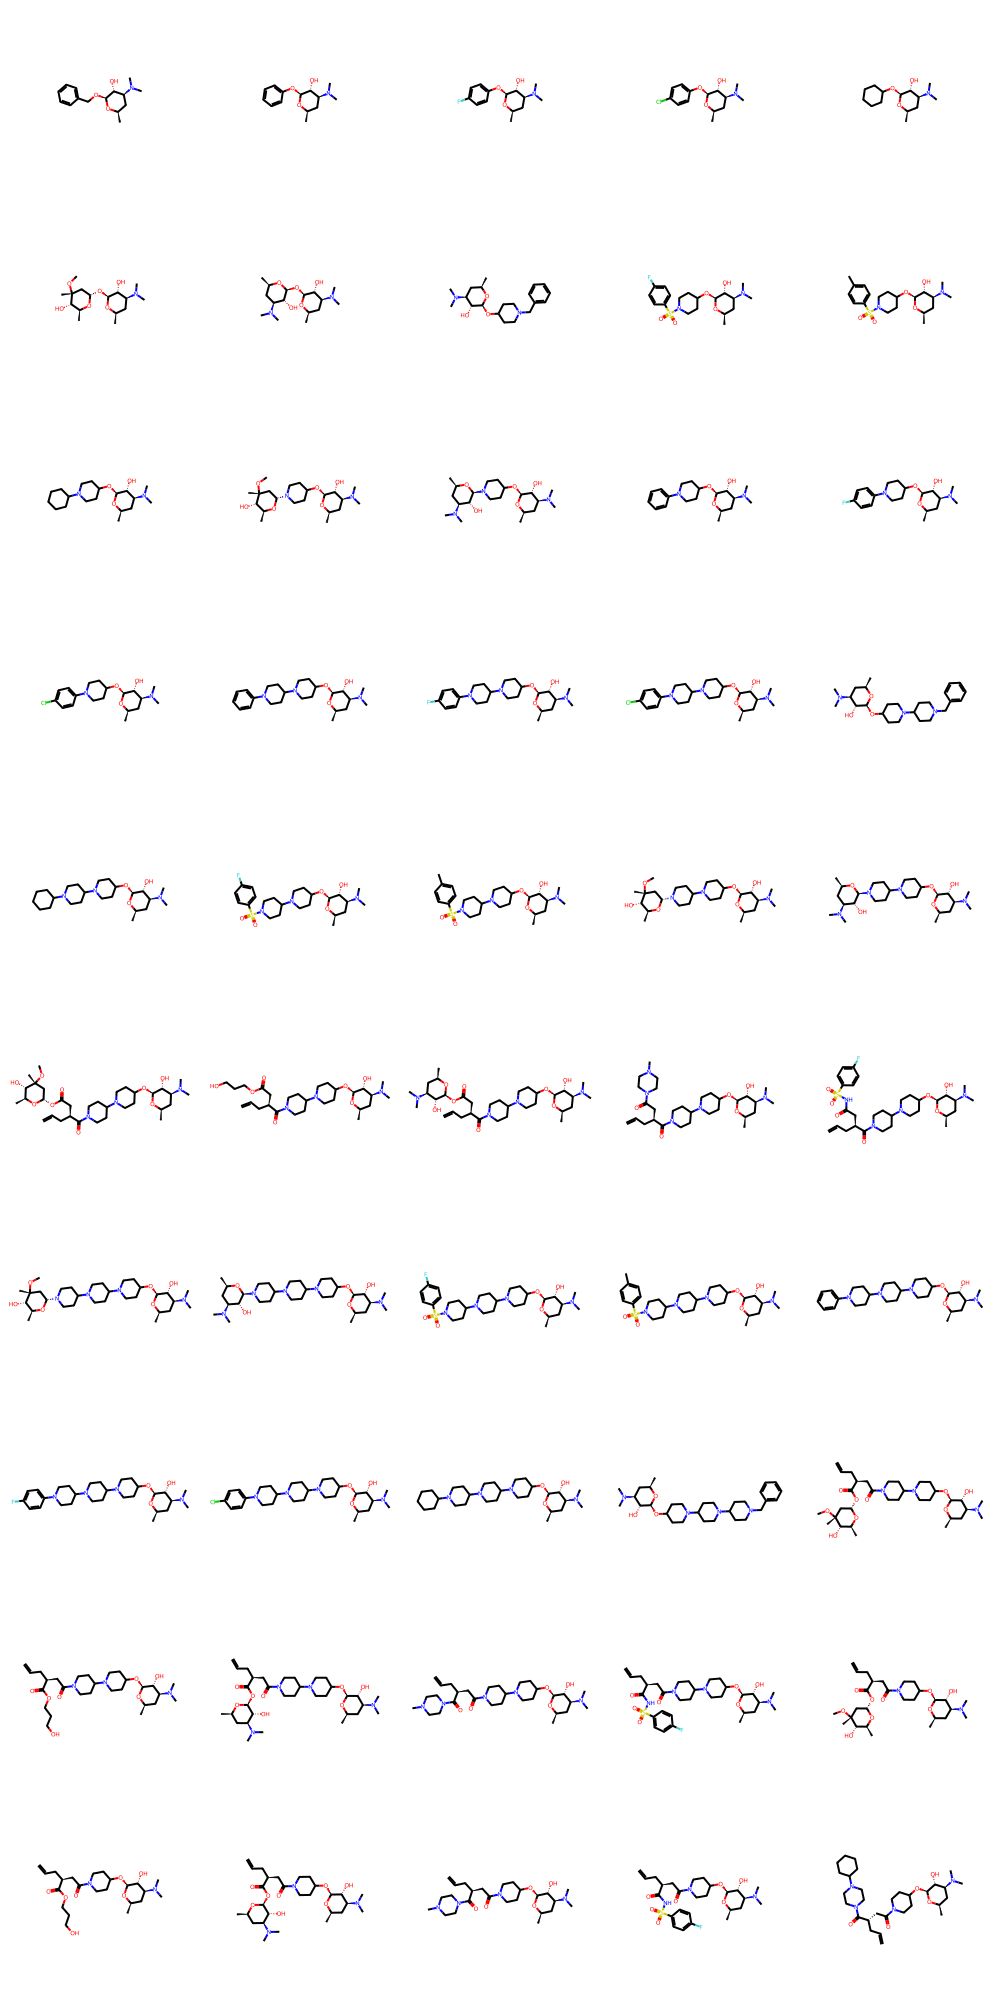

In [18]:
import random
random.seed(400)
print(type(fragmol_top20))
print(type(fragmol_top20[1]))
#fragms = [Chem.MolFromSmiles(x) for x in frag_top20]
fragms=fragmol_top20
ms = BRICS.BRICSBuild(fragms)
prods = [next(ms) for x in range(100)]
[prod.UpdatePropertyCache(strict=False) for prod in prods]
prods_smiles = [Chem.MolToSmiles(i) for i in prods]
df =pd.DataFrame(prods_smiles)
df.to_csv("combine_pos_smiles.csv",index=0)
Draw.MolsToGridImage(prods,molsPerRow=5)

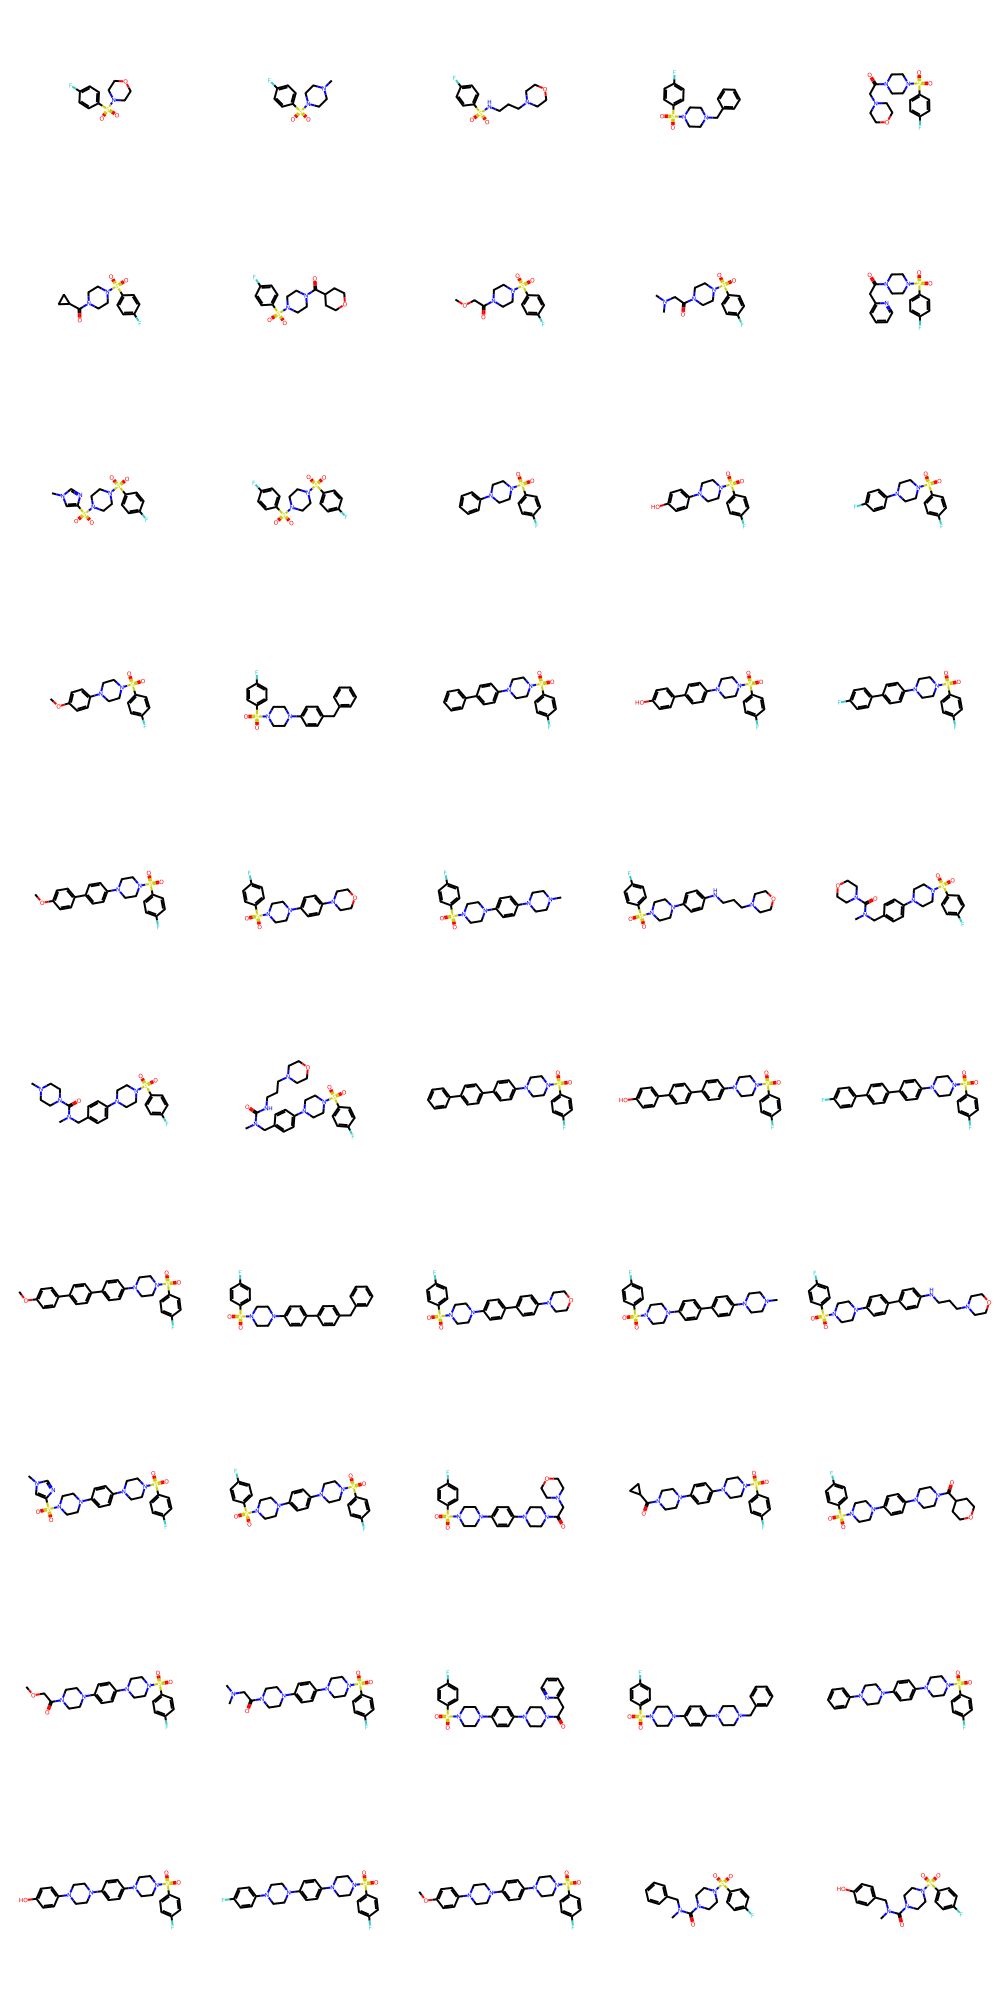

In [19]:
import random
random.seed(400)
#print(type(negative_fragmol_top20))
#print(type(negative_fragmol_top20[1]))
#fragms = [Chem.MolFromSmiles(x) for x in frag_top20]
fragms=negative_fragmol_top20
ms = BRICS.BRICSBuild(fragms)
prods = [next(ms) for x in range(100)]
[prod.UpdatePropertyCache(strict=False) for prod in prods]
prods_smiles = [Chem.MolToSmiles(i) for i in prods]
df =pd.DataFrame(prods_smiles)
df.to_csv("combine_neg_smiles.csv",index=0)
Draw.MolsToGridImage(prods,molsPerRow=5)